### Analysis of model trained on UniRef90 dataset for multiclass classification

In [21]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/..']

In [29]:
from src.prediction.models.nlp.transformer import ClassificationTransformer
from src.utils import nn_utils

import torch
import torch.nn.functional as F

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [87]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230406-1/host_multi/trained_transformer_model.pth"

host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 64,
    "sequence_max_length": 1024,
    "pad_sequence_val": 0
}

label_settings = {
    "label_col": "virus_host_name",
    "label_classes": host_classes,
}

In [24]:
nlp_model = ClassificationTransformer(n_tokens=27, seq_len=sequence_settings["sequence_max_length"], n_classes=len(host_classes), N=6, d=512, d_ff=2048, h=8)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())

In [77]:
def compute_mean_attn_values():
    attn_values = nlp_model.encoder.layers[5].self_attn.self_attn.squeeze()
    return torch.mean(attn_values, dim=0)


def plot_mean_attention_values(x, seq=None, seq_len=None):
    ticklabels = seq.cpu().detach().numpy().squeeze()[:seq_len]
    ticklabels_mapped = [idx_amino_acid_map[x] for x in ticklabels]

    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.figure(figsize=(12,12))
    data = x.cpu().detach().numpy()
    sns.heatmap(data=data[:seq_len, :seq_len], xticklabels=ticklabels_mapped, yticklabels=ticklabels_mapped)
    #plt.xticks(rotation=20)
    plt.show()


def plot_mean_of_mean_attention_values(x, seq=None, seq_len=None):
    x = torch.mean(x, dim=0)
    tokens = seq.cpu().detach().numpy().squeeze()
    df = pd.DataFrame({"tokens": tokens, "attn_vals": x.cpu().detach().numpy(), "pos": range(512)})
    df["tokens"] = df["tokens"].map(idx_amino_acid_map)
    df = df.dropna()
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df, x="pos", y="attn_vals", hue="tokens")
    plt.show()

In [76]:
def analyze_prediction(sample_seq, sample_label):
    sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(f"seq_len = {seq_len}")

    sample_pred = torch.argmax(F.softmax(nlp_model(sample_seq), dim=1), dim=1)
    print(f"Label = {index_label_map[sample_label.item()]}")
    print(f"Prediction = {index_label_map[sample_pred.item()]}")
    mean_attn_values = compute_mean_attn_values()

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)

Read dataset from /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s12612648/uniref90_final.csv_tr0.8_test.csv, size = (3819, 2)
index_label_map
{0: 'Homo sapiens', 1: 'Phacochoerus aethiopicus', 2: 'Bandicota bengalensis', 3: 'Equus caballus', 4: 'Capra hircus', 5: 'Gallus gallus', 6: 'Apodemus sylvaticus', 7: 'Bos taurus', 8: 'Others', 9: 'Others'}
seq_len = 338
Label = Homo sapiens
Prediction = Homo sapiens


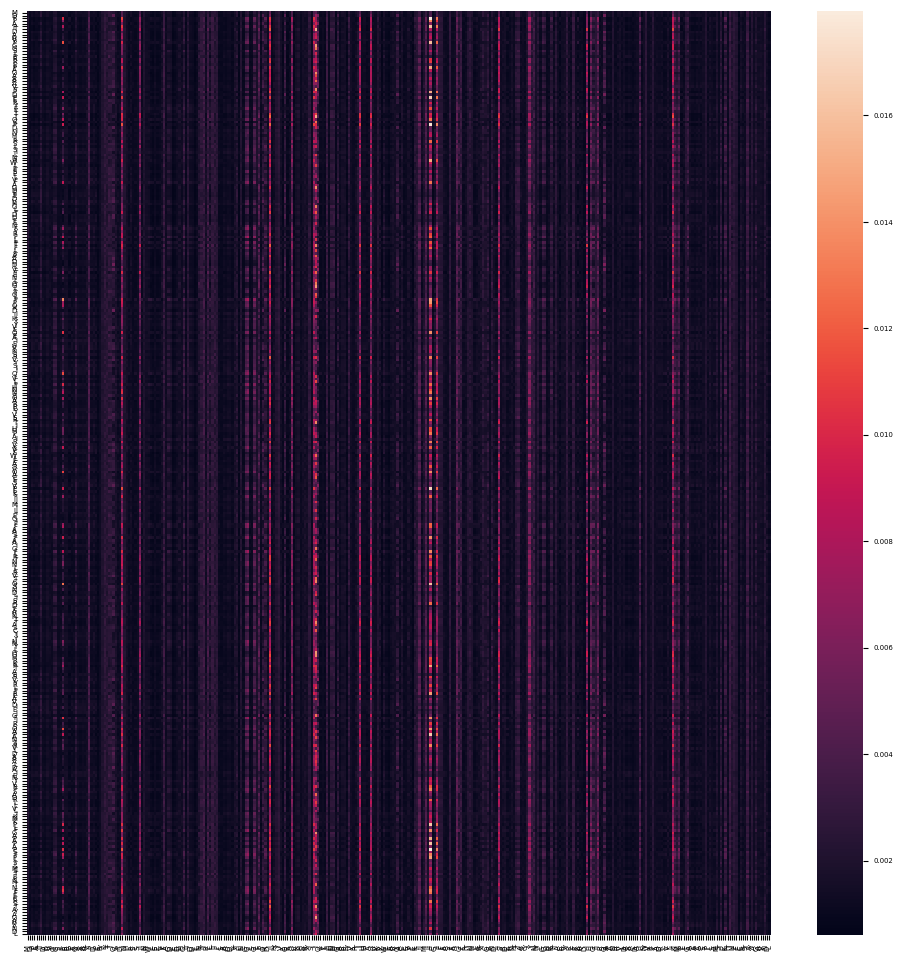

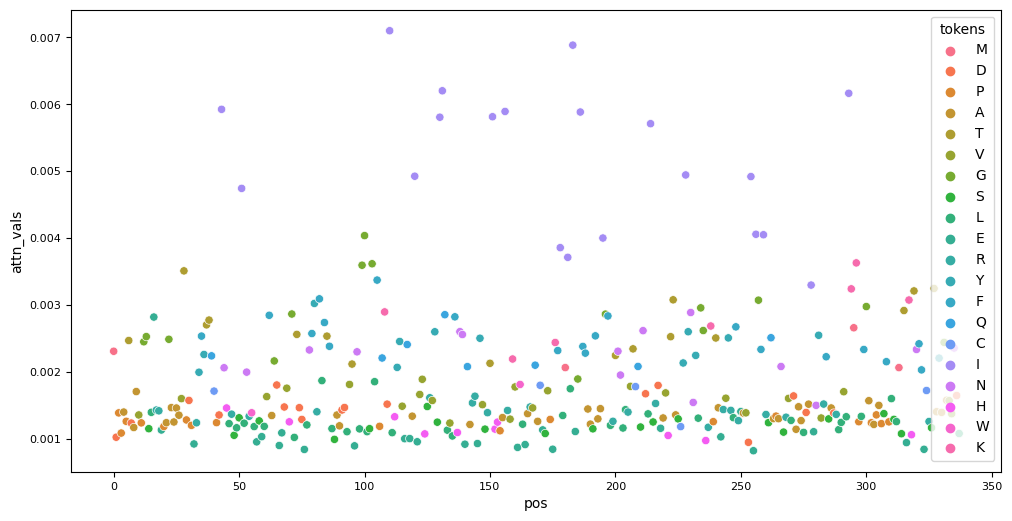

In [79]:
# test_filepath = "~/dev/git/zoonosis/input/data/uniref90/splits/s12612648/uniref90_final.csv_tr0.8_test.csv"
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits"
input_settings = {
    "dir": "s12612648",
    "test": [ "uniref90_final.csv_tr0.8_test.csv" ]
}

index_label_map, test_dataset_loader = nn_utils.get_dataset_loader(input_dir, input_settings, sequence_settings, label_settings, dataset_type="test")
print(f"index_label_map\n{index_label_map}")
for _, record in enumerate(test_dataset_loader):
    sequence, label = record

analyze_prediction(sequence[5], label[5])

In [88]:
# test_filepath = "~/dev/git/zoonosis/input/data/uniref90/splits/s12612648/uniref90_final.csv_tr0.8_test.csv"
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input"
input_settings = {
    "dir": "data",
    "test": [ "sars_cov2_zoonosis.csv" ]
}

index_label_map, test_dataset_loader = nn_utils.get_dataset_loader(input_dir, input_settings, sequence_settings, label_settings, dataset_type="test")
print(f"index_label_map\n{index_label_map}")
for _, record in enumerate(test_dataset_loader):
    sequence, label = record

Read dataset from /home/grads/blessyantony/dev/git/zoonosis/input/data/sars_cov2_zoonosis.csv, size = (2, 2)
index_label_map
{0: 'Homo sapiens', 1: 'Phacochoerus aethiopicus', 2: 'Bandicota bengalensis', 3: 'Equus caballus', 4: 'Capra hircus', 5: 'Gallus gallus', 6: 'Apodemus sylvaticus', 7: 'Bos taurus', 8: 'Others', 9: 'Others'}


In [89]:
analyze_prediction(sequence[0], label[0])

seq_len = 1024


../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [75,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [75,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [75,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [75,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [75,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [75,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [75,0,0],

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


`srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [105,0,0], thread: [78,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [105,0,0], thread: [79,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [105,0,0], thread: [80,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [105,0,0], thread: [81,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [105,0,0], thread: [82,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [105,0,0], thread: [83,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:114

seq_len = 512
Label = Homo sapiens
Prediction = Others


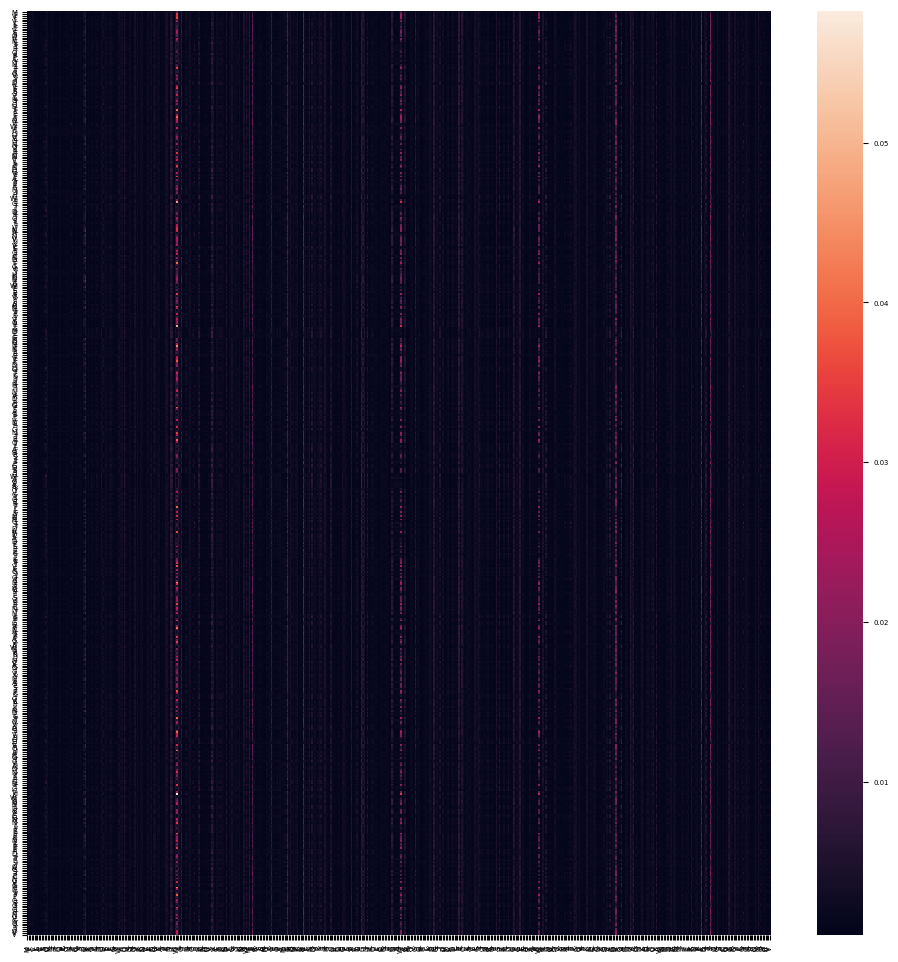

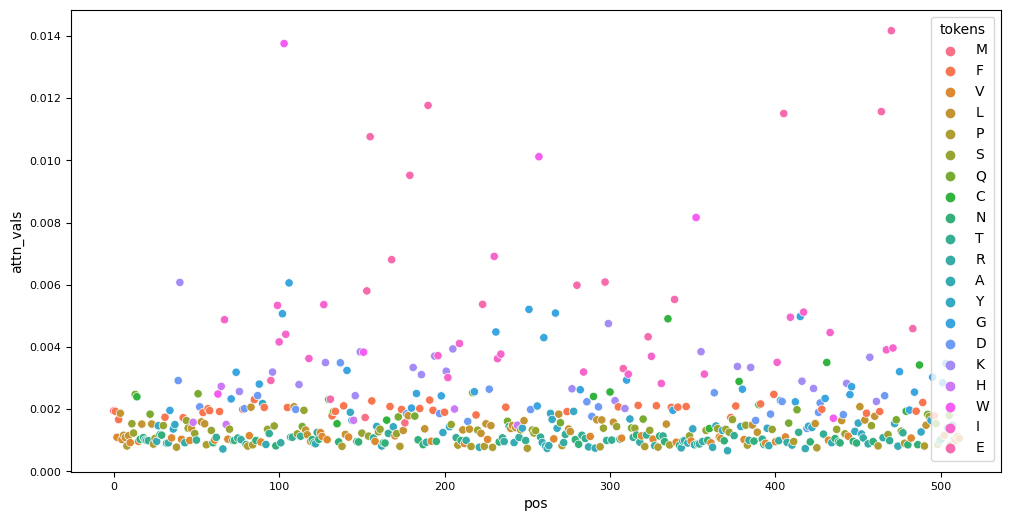

In [86]:
analyze_prediction(sequence[1], label[1])